In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import zipfile
import io
import pandas as pd
import keras
from keras.preprocessing.image import img_to_array

In [2]:
torch.manual_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unrar x "/content/gdrive/MyDrive/feret_images.rar" "/content/gdrive/MyDrive/unrar_image/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/MyDrive/feret_images.rar


Would you like to replace the existing file /content/gdrive/MyDrive/unrar_image/feret_images/00001.tif
 98598 bytes, modified on 2022-06-08 20:56
with a new one
 98598 bytes, modified on 2022-06-08 20:56

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


In [ ]:
!unrar x "/content/gdrive/MyDrive/original_sketch.rar" "/content/gdrive/MyDrive/unrar_sketch/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/MyDrive/original_sketch.rar

Creating    /content/gdrive/MyDrive/unrar_sketch/original_sketch      OK
Extracting  /content/gdrive/MyDrive/unrar_sketch/original_sketch/00001.jpg       0%  OK 
Extracting  /content/gdrive/MyDrive/unrar_sketch/original_sketch/00002.jpg       0%  OK 
Extracting  /content/gdrive/MyDrive/unrar_sketch/original_sketch/00003.jpg       0%  OK 
Extracting  /content/gdrive/MyDrive/unrar_sketch/original_sketch/00004.jpg       0%  OK 
Extracting  /content/gdrive/MyDrive/unrar_sketch/original_sketch/00005.jpg       0%  OK 
Extracting  /content/gdrive/MyDrive/unrar_sketch/original_sketch/00006.jpg       0%  OK 
Extracting  /content/gdrive/MyDrive/unrar_sketch/original_sketch/00007.jpg       0%  OK 
Extracting  /content/gdrive/MyDrive/unrar_sketch/original_sketch/00008.jpg       0%  OK 
Extracting  /

In [4]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


In [5]:
image_file = sorted_alphanumeric(os.listdir("/content/gdrive/MyDrive/unrar_image/feret_images"))

In [6]:
sketch_file = sorted_alphanumeric(os.listdir("/content/gdrive/MyDrive/unrar_sketch/original_sketch"))

In [7]:
SIZE = 256
img_array = []
sketch_array = []

In [8]:
for i in tqdm(image_file):
    image = cv2.imread("/content/gdrive/MyDrive/unrar_image/feret_images" + '/' + i,cv2.IMREAD_GRAYSCALE)
    
    # as opencv load image in bgr format converting it to rgb
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    #img1 = cv2.flip(image,1)
    #img_array.append(img_to_array(img1))
     

100%|██████████| 1194/1194 [00:20<00:00, 59.55it/s] 


In [9]:
for i in tqdm(sketch_file):
    image = cv2.imread("/content/gdrive/MyDrive/unrar_sketch/original_sketch" + '/' + i,cv2.IMREAD_GRAYSCALE)
    
    # as opencv load image in bgr format converting it to rgb
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    #img1 = cv2.flip(image,1)
    #sketch_array.append(img_to_array(img1))
    

100%|██████████| 1194/1194 [05:33<00:00,  3.58it/s]


In [10]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 1194
Total number of images: 1194


In [ ]:
 # defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'red', fontsize = 20)
    plt.imshow(sketches[:,:,0], cmap='gray')
   
    plt.show()

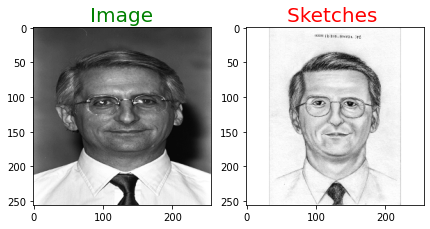

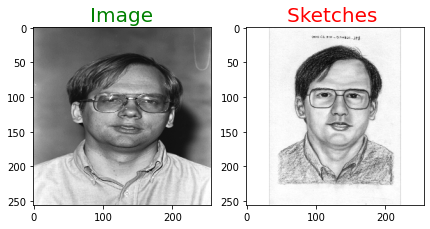

In [ ]:
ls = [i for i in range(0,40,20)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])

In [11]:
Y_trainn = sketch_array[:955]
X_trainn = img_array[:955]
Y_testt = sketch_array[955:]
X_testt = img_array[955:]

In [ ]:
print(X_trainn[0].shape)
#print(X_train[0])
#print(Y_train[0])

(256, 256, 1)


In [ ]:
Y_train = np.array(Y_trainn)
X_train = np.array(X_trainn)
Y_test = np.array(Y_testt)
X_test = np.array(X_testt)
#print(X_train[0])

In [12]:

torch_X_train = torch.tensor(X_trainn)
torch_y_train = torch.tensor(Y_trainn)

torch_X_train = torch_X_train.view(-1,1,256,256).float()
torch_y_train = torch_y_train.view(-1,1,256,256).float()
print(torch_X_train.shape)
print(torch_y_train.shape)
print(torch_X_train[0])
print(torch_y_train[1])

torch.Size([955, 1, 256, 256])
torch.Size([955, 1, 256, 256])
tensor([[[0.4039, 0.4000, 0.3843,  ..., 0.3882, 0.4039, 0.4078],
         [0.3961, 0.3882, 0.3804,  ..., 0.4000, 0.4039, 0.4039],
         [0.3765, 0.3804, 0.3765,  ..., 0.3961, 0.4000, 0.4039],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9922, 0.9922],
         [0.9961, 0.9961, 0.9961,  ..., 0.9882, 0.9922, 0.9922],
         [0.9961, 0.9961, 0.9961,  ..., 0.9922, 0.9922, 0.9961]]])
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


In [ ]:
ff = torch_X_train[0].detach().numpy()
ff = torch_X_train[0].reshape(256,256,1)
hh = torch_y_train[0].detach().numpy()
hh = torch_y_train[0].reshape(256,256,1)

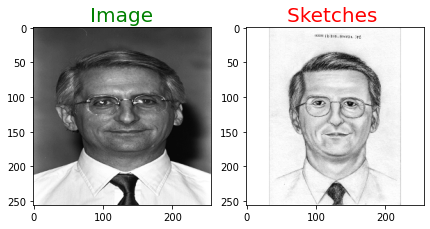

In [ ]:
plot_images(ff,hh)

In [13]:
torch_X_test = torch.tensor(X_testt)
torch_y_test = torch.tensor(Y_testt)
torch_X_test = torch_X_test.view(-1,1,256,256).float()
torch_y_test = torch_y_test.view(-1,1,256,256).float()
print(torch_X_test.shape)
print(torch_y_test.shape)
#print(torch_X_test[0])
#print(torch_y_test[1])

torch.Size([239, 1, 256, 256])
torch.Size([239, 1, 256, 256])


In [14]:
BATCH_SIZE = 1

In [15]:
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

In [16]:
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [17]:
it = iter(train_loader)
X_batch, y_batch = next(it)
print(X_batch.shape)
print(y_batch.shape)
#print(y_batch[0])

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [18]:
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx == 0:
        print(data.shape)
        print(target.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [19]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size = 3),
            nn.BatchNorm2d(8), 
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size = 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size = 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size = 3),
            nn.Dropout2d(),
          )
          
          
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(256, 128, kernel_size = 2, stride= 2), 
            nn.Upsample(scale_factor=2),
            #nn.BatchNorm2d(256),
            #nn.ReLU(),
            #nn.Upsample(scale_factor=2),
            #nn.Conv2d(128, 256, kernel_size = 5),
            nn.Conv2d(256, 256, kernel_size = 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size = 3),
            #nn.Conv2d(256, 256, kernel_size = 5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3),
            #nn.ConvTranspose2d(256, 128,  kernel_size = 2, stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            #nn.ConvTranspose2d(128, 64,  kernel_size = 2, stride = 2),
            #nn.BatchNorm2d(128),
            #nn.ReLU(),
            #nn.Upsample(scale_factor=2),
            #nn.ConvTranspose2d(64, 32,  kernel_size = 2, stride = 2),
            nn.Conv2d(128, 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.ConvTranspose2d(32, 1,  kernel_size = 2, stride = 2),
            nn.Conv2d(64,32, kernel_size = 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32,16, kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16,8, kernel_size = 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8,1, kernel_size = 3),
            nn.Sigmoid(),
          )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded
      

In [20]:
autoencoder = AutoEncoder()
print(autoencoder)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=

In [21]:
it = iter(train_loader)
X_batch, y_batch = next(it)
print(X_batch.shape)
print(X_batch.type())
print(y_batch.shape)
print(torch.min(X_batch), torch.max(X_batch), torch.mean(X_batch))
print(torch.min(y_batch), torch.max(y_batch), torch.mean(y_batch))

if torch.cuda.is_available():
    X_batch = X_batch.cuda()
    y_batch = y_batch.cuda()
#print(X_batch)
print(autoencoder.forward(X_batch).shape)

torch.Size([1, 1, 256, 256])
torch.FloatTensor
torch.Size([1, 1, 256, 256])
tensor(0.0941) tensor(0.9137) tensor(0.4609)
tensor(0.0745) tensor(1.) tensor(0.8560)
torch.Size([1, 1, 256, 256])


In [22]:
learning_rate = 0.0002
momentum = 0.5
n_epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
scheduler = StepLR(optimizer,step_size=1 , gamma=0.9)

In [23]:
train_losses = []
train_counter = []
test_losses = []
outputtrain = []
outputtest = []

In [24]:
def train(epoch):
    autoencoder.train()
    
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = autoencoder(data)
        outputtrain.append(output.data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        

        if batch_idx % 300 == 0: #every 25 * batchsize sample we print results
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
      
        train_loss += loss.item()

    scheduler.step()
    train_losses.append(train_loss)
    train_counter.append(epoch)

    torch.save(autoencoder.state_dict(), 'model.pth')
    torch.save(autoencoder.state_dict(), 'optimizer.pth')

In [25]:
def test():
  autoencoder.eval()
  test_loss = 0
  
  #correct = 0
  with torch.no_grad():
    for data, target in test_loader:

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = autoencoder(data)
        outputtest.append(output.data)
        test_loss += criterion(output, target).item()
        #pred = output.data.max(1, keepdim=True)[1]
        #correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))

In [26]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/955 (0%)]	Loss: 0.193819
Train Epoch: 1 [300/955 (31%)]	Loss: 0.049066
Train Epoch: 1 [600/955 (63%)]	Loss: 0.047825
Train Epoch: 1 [900/955 (94%)]	Loss: 0.045113

Test set: Avg. loss: 0.0529
Train Epoch: 2 [0/955 (0%)]	Loss: 0.049777
Train Epoch: 2 [300/955 (31%)]	Loss: 0.035892
Train Epoch: 2 [600/955 (63%)]	Loss: 0.054925
Train Epoch: 2 [900/955 (94%)]	Loss: 0.043756

Test set: Avg. loss: 0.0547
Train Epoch: 3 [0/955 (0%)]	Loss: 0.054650
Train Epoch: 3 [300/955 (31%)]	Loss: 0.055465
Train Epoch: 3 [600/955 (63%)]	Loss: 0.044849
Train Epoch: 3 [900/955 (94%)]	Loss: 0.075177

Test set: Avg. loss: 0.0565
Train Epoch: 4 [0/955 (0%)]	Loss: 0.047117
Train Epoch: 4 [300/955 (31%)]	Loss: 0.044985
Train Epoch: 4 [600/955 (63%)]	Loss: 0.065815
Train Epoch: 4 [900/955 (94%)]	Loss: 0.065193

Test set: Avg. loss: 0.0531
Train Epoch: 5 [0/955 (0%)]	Loss: 0.054871
Train Epoch: 5 [300/955 (31%)]	Loss: 0.062550
Train Epoch: 5 [600/955 (63%)]	Loss: 0.087509
Train Epoch: 5 [900/955 (

In [27]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real[:, :, 0] , cmap='gray')
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch[:, :, 0] , cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted[:, :, 0] , cmap='gray')

In [28]:
yy = sketch_array[955:]
xx = img_array[955:]
xtr = img_array[ : 955]
ytr = sketch_array[ : 955]

In [29]:
lts = (n_epochs - 2) * len(xx)
ltss =  (n_epochs - 1) * len(xx)
outtest = outputtest[ lts : ltss ]
ltr = (n_epochs - 2) * len(xtr)
ltrr = (n_epochs - 1) * len(xtr)
outtrain = outputtrain[ ltr : ltrr ]

In [31]:
print(len(outtrain))
print(len(outtest))

955
239


In [53]:
kk = outtest[237]
#pp = outputtest[1199]
print(kk.size())
#print(pp.size())

torch.Size([1, 1, 256, 256])


In [54]:
gg = outtrain[953]
gg.size()

torch.Size([1, 1, 256, 256])

In [55]:
kk = kk.detach().numpy()
gg = gg.detach().numpy()

In [56]:
kk = kk.reshape(256,256,1)
gg = gg.reshape(256,256,1)

None


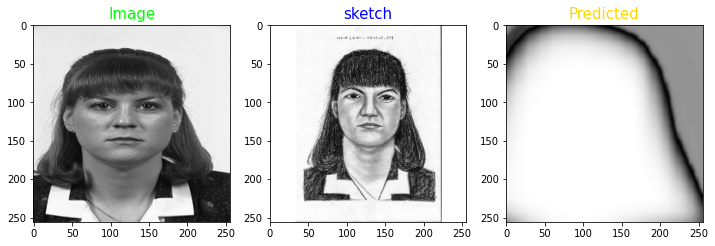

In [57]:
print(show_images(xx[237], yy[237], kk))

None


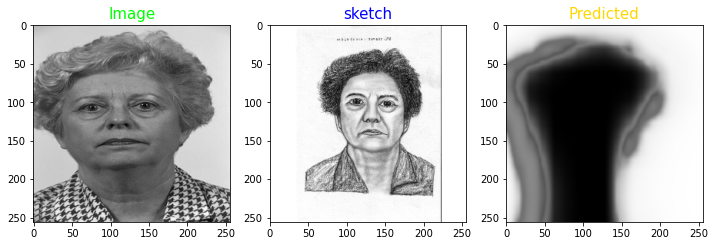

In [58]:
print(show_images(xtr[953], ytr[953], gg))